# Import Required Libraries
Import the necessary libraries, including NumPy, Matplotlib, and Matplotlib's animation module.

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# matplotlib.use('Agg')
%matplotlib widget

# Define Functions for Simulation
Define the functions `update_propensities`, `sample_discrete`, `gillespie_draw`, and `gillespie` for running the Gillespie simulation.

In [2]:
# Define the functions for the Gillespie simulation

# Function to update the propensities of the reactions depending on the state of the filament
def update_propensities(propensities, filament, concentration, ratio, rates):
    '''
    Args:
        propensities: (np.array) Array with the propensities of the reactions.
        filament: (list) List of the states of the monomers in the filament.
        concentration: (float) Concentration of tubulin.
        rates: (np.array) Array with the intrinsic rates of the reactions.
        ratio: (float) Ratio between the rates of polymerization of GDP-bound and GTP-bound monomers.
    Returns:
        propensities: (np.array) Array with the updated propensities of the reactions.
    '''
    # calculate the number of GTP bound tubulin
    n_gtp = sum(filament)

    k_gtpPolymerization = rates[0] * concentration
    k_gdpPolymerization = k_gtpPolymerization * ratio
    k_gtpDepolymerization = rates[1]
    k_gdpDepolymerization = rates[2]
    k_hydrolysis = rates[3] * n_gtp

    if filament[-1] == 1:  # if the last monomer is GTP bound
        propensities[0] = k_gtpPolymerization
        propensities[1] = k_gtpDepolymerization
    else:  # if the last monomer is GDP bound
        propensities[0] = k_gdpPolymerization
        propensities[1] = k_gdpDepolymerization

    propensities[2] = k_hydrolysis

    return propensities

# Function to sample the next reaction to occur
def sample_discrete(propensities):
    '''
    Args:
        propensities: (np.array) Array with the propensities of the reactions.
    Returns:
        index: (int) Index of the reaction that occurs.
        0. Polymerization
        1. Depolymerization
        2. Hydrolysis
    '''
    # calculate the total propensity
    total_propensity = sum(propensities)

    # sample a random number
    r = np.random.rand()

    # calculate the cumulative sum of the propensities
    cum_sum = np.cumsum(propensities)

    # find the index of the reaction that occurs
    index = np.searchsorted(cum_sum, r * total_propensity)

    return index

# Function to draw the next time and reaction to occur
def gillespie_draw(propensity_func, propensities, filament, *args):
    '''
    Args:
        propensity_func: (function) Function to update the propensities of the reactions.
        propensities: (np.array) Array with the propensities of the reactions.
        filament: (list) List of the states of the monomers in the filament.
        *args: Additional arguments for the propensity function.
    Returns:
        tau: (float) Time until the next reaction occurs.
        index: (int) Index of the reaction that occurs.
    '''
    # update the propensities
    propensities = propensity_func(propensities, filament, *args)

    # calculate the total propensity
    total_propensity = sum(propensities)

    # sample the time until the next reaction occurs
    tau = np.random.exponential(1.0 / total_propensity)

    # sample the reaction that occurs
    index = sample_discrete(propensities)

    return tau, index

# Function to run the simulation of the Gillespie algorithm
def gillespie(t_max, concentration, ratio):
    '''
    Args:
        t_max: (float) Maximum time of the simulation.
        concentration: (float) Concentration of tubulin.
        ratio: (float) Ratio between the rates of polymerization of GDP-bound and GTP-bound monomers
    Returns:
        t: (list) List with the times of the simulation.
        len: (list) List with the length of the filament at each time.
        filaments: (list) List of filament states at each time.
    '''
    # initialization
    t = [0.0]
    filament = [1] * 100
    l_t = [len(filament)]
    propensities = np.array([0, 0, 0])
    filaments = [filament.copy()]

    # intrinsic rates for reactions
    rates = np.array([3.2e6, 24, 290, 0.5])

    # run the simulation
    while t[-1] < t_max:
        tau, index = gillespie_draw(update_propensities, propensities, filament, concentration, ratio, rates)
        t.append(t[-1] + tau)

        if index == 0:  # polymerization
            filament.append(1)
        elif index == 1:  # depolymerization
            filament.pop()
        else:  # hydrolysis of a GTP-bound monomer
            gtp_monomers = [i for i, x in enumerate(filament) if x == 1]
            i = np.random.choice(gtp_monomers)
            filament[i] = 0

        l_t.append(len(filament))
        filaments.append(filament.copy())

        if len(filament) == 1:
            break

    return t, l_t, filaments

# Animate Microtubule Filament
Use Matplotlib's animation module to animate the microtubule filament vs time, with different colors for GTP and GDP bound monomers.

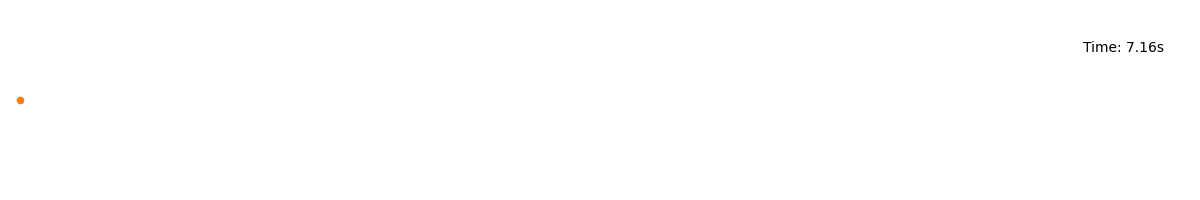

In [5]:
t, l_t, filaments = gillespie(10, concentration=10e-6, ratio=0.01)

# Set up the figure for animation
fig, ax = plt.subplots(figsize=(12, 2))
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)  # Adjust layout to reduce padding
ax.axis('off')  # Remove all axes for a clean look

# Function to initialize the animation
def init():
    ax.clear()
    ax.axis('off')
    return []

# Function to update the animation
def update(frame):
    ax.clear()
    ax.axis('off')
    
    # Get the filament for the current frame and set the x positions with spacing
    filament = filaments[frame]
    x_positions = np.arange(len(filament))

    # Set plot limits based on the scaled filament length
    max_length = max(len(f) for f in filaments)
    ax.set_xlim(-1, (max_length + 1))  # Start from 0 to minimize left padding
    ax.set_ylim(-1, 1)
    
    # Colors based on the state of each monomer (GTP: blue, GDP: red)
    colors = ['C0' if state == 1 else 'C1' for state in filament]
    
    # Draw circles for each monomer using scatter
    ax.scatter(x_positions, np.zeros_like(x_positions), s=20, c=colors, alpha=1.0)
    
    # Display the time at the top-right corner
    ax.text(0.98, 0.8, f'Time: {t[frame]:.2f}s', ha='right', va='top', transform=ax.transAxes, fontsize=10, color='black')

    return []

# Create the animation
ani = FuncAnimation(fig, update, frames=len(filaments), init_func=init, blit=True)
ani.save('microtubule_filament_animation.mp4', writer='ffmpeg', fps=20)

plt.show()